In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import torch
import torch.nn as nn
import pandas as pd

In [3]:
class Policy(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=32, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

Epoch 001 | Train Loss: 0.228316 | Val Loss: 0.230053
Epoch 051 | Train Loss: 0.149701 | Val Loss: 0.146530
Epoch 101 | Train Loss: 0.074409 | Val Loss: 0.063920
Epoch 151 | Train Loss: 0.029937 | Val Loss: 0.016943
Epoch 201 | Train Loss: 0.015759 | Val Loss: 0.005372
Epoch 251 | Train Loss: 0.015133 | Val Loss: 0.004171
Epoch 301 | Train Loss: 0.014256 | Val Loss: 0.004032
Epoch 351 | Train Loss: 0.013150 | Val Loss: 0.003935
Epoch 401 | Train Loss: 0.013123 | Val Loss: 0.003871
Epoch 451 | Train Loss: 0.013357 | Val Loss: 0.003780
Epoch 501 | Train Loss: 0.012560 | Val Loss: 0.003728
Epoch 551 | Train Loss: 0.010143 | Val Loss: 0.003663
Epoch 601 | Train Loss: 0.010690 | Val Loss: 0.003605
Epoch 651 | Train Loss: 0.010891 | Val Loss: 0.003564
Epoch 701 | Train Loss: 0.012002 | Val Loss: 0.003531
Epoch 751 | Train Loss: 0.011257 | Val Loss: 0.003525
Epoch 801 | Train Loss: 0.008408 | Val Loss: 0.003540
Epoch 851 | Train Loss: 0.008870 | Val Loss: 0.003535
Epoch 901 | Train Loss: 0.00

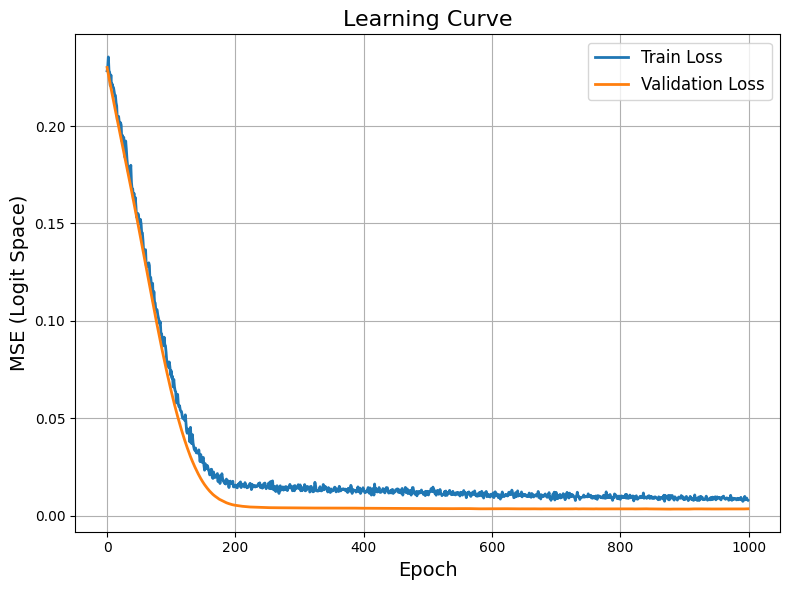


Evaluation Metrics on Validation Set:
MSE  = 0.000207
MAE  = 0.010558
R²   = -1.2099
MAPE = 2.72%


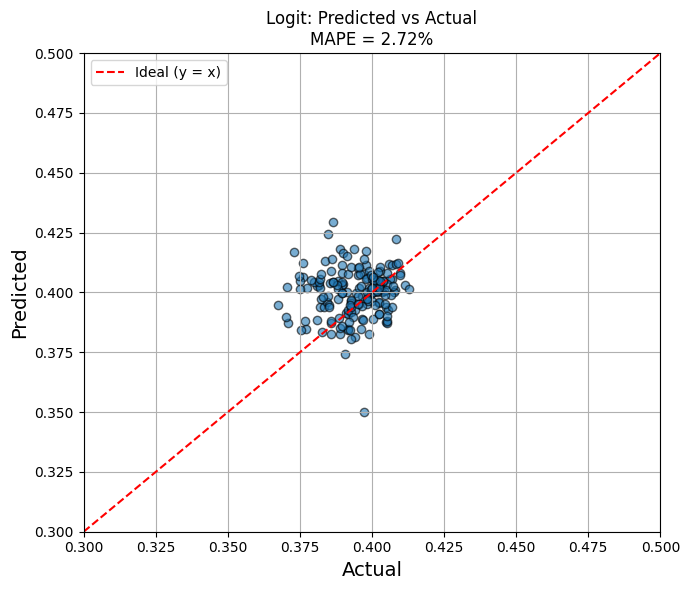

In [5]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Logit & Inverse Logit Functions ===
def logit(y, eps=1e-5):
    y = np.clip(y, eps, 1 - eps)
    return np.log(y / (1 - y))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

# === Data Loading Function ===
def load_model_features_and_labels():
    features = []
    labels = []
    root_folders = ["./Policys/0.0-0.1/", "./Policys/0.1-0.2/", "./Policys/0.2-0.3/"]
    label_file = "CL_list.txt"
    
    for m in range(3):
        bin = 0.1 * m
        label = np.loadtxt(os.path.join(f"./Results/KL_Critical_Value_Check_EXP/{bin:.1f}-{bin+0.1:.1f}/", label_file))
        labels.extend(label)

    for root_folder in root_folders:
        for file_name in os.listdir(root_folder):
            model_path = os.path.join(root_folder, file_name)
            model = torch.load(model_path)
            flat_params = []
            for param in model.parameters():
                flat_params.append(np.array(param.detach().cpu().tolist()).flatten())
            features.append(np.concatenate(flat_params))

    return np.array(features), labels

# === Load Features and Labels ===
X, y = load_model_features_and_labels()
X_tensor = torch.tensor(X, dtype=torch.float32)
y_logit_tensor = torch.tensor(logit(np.array(y)), dtype=torch.float32).unsqueeze(1)

# === Dataset and DataLoaders ===
dataset = TensorDataset(X_tensor, y_logit_tensor)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# === MLP Model (No Sigmoid) ===
class KLRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# === Train ===
model = KLRegressor(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)
loss_fn = nn.MSELoss()

train_losses, val_losses = [], []

for epoch in range(1000):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 50 == 0 or epoch == 999:
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# === Plot Learning Curve ===
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE (Logit Space)', fontsize=14)
plt.title('Learning Curve', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Evaluation (Convert Back to [0,1]) ===
model.eval()
y_true_logit, y_pred_logit = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        pred = model(xb)
        y_true_logit.extend(yb.squeeze().tolist())
        y_pred_logit.extend(pred.squeeze().tolist())

# Convert both back to [0,1]
y_true = inv_logit(np.array(y_true_logit))
y_pred = inv_logit(np.array(y_pred_logit))

# === Metrics ===
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\nEvaluation Metrics on Validation Set:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.2f}%")

# === Scatter Plot ===
plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0.3, 0.5], [0.3, 0.5], 'r--', label="Ideal (y = x)")
plt.xlabel("Actual", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.title(f"Logit: Predicted vs Actual\nMAPE = {mape:.2f}%")
plt.xlim(0.3, 0.5)
plt.ylim(0.3, 0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save model weights
torch.save(model.state_dict(), "Hi_CoLA_net.pth")